In [1]:
from collections import defaultdict
import csv
import json
import sys
import re
import numpy as np
import matplotlib.pyplot as plt
import string
from operator import itemgetter
from dateutil import parser
import twitter_text
import itertools
import pandas as pd
import scipy
import pickle
import itertools
# %matplotlib inline
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
plt.style.use("ggplot")
font = FontProperties(fname=r"/Users/qinqiang/personal/tweets/msyh.ttf", size=14) 
# from pandas.lib import Timestamp
# from pandas.core import datetools
# import ggplot as gg
import networkx as nx

from sklearn.cluster import KMeans  
from sklearn.decomposition import PCA
from wordcloud import WordCloud
import community
import RAKE
import pydlm

In [2]:
def flushPrint(s):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % s)
    sys.stdout.flush()


with open("/Users/qinqiang/personal/tweets/stopwords_en.txt") as f:
    stop_words_raw = f.readlines()
stop_words =[i.replace("\n", "") for i in stop_words_raw]

In [349]:
def extract_rt_user(tweet):
    rt_patterns = re.compile(r"(rt|via|RT|VIA|Rt)\s*(@\w+:?)", re.IGNORECASE)
    try:
        rt_user_name = rt_patterns.findall(tweet)[0][1].strip('@').strip(":")
        return rt_user_name
    except IndexError as e:
        pass

def cleanTweet(tweet):
    tweet = tweet.strip() 
    rt_name = extract_rt_user(tweet)
    ex = twitter_text.Extractor(tweet)
    at_names = ex.extract_mentioned_screen_names()
    urls = ex.extract_urls()
    hashtags = ex.extract_hashtags()
    for at in at_names:
        tweet = tweet.replace(at, "")
    for j in urls:
        tweet = tweet.replace(j, "")
    tweet = tweet.replace('RT @',"" ).replace("RT@","").replace('@', "").replace('"', "").replace('#', "")
    seps = ["",'(', ')',"&", '!', ':', '.', '?', ',', '=', u'\xa0', '/', '\\', '\n', '-', '|', ';', u'&amp', '*', "'", '+']
    for s in seps:
        tweet = tweet.replace(s, "")
    nonsense = ["xee","x94", "x8c","x80","x9d","xe2","xc2","xa0","x9c","x98","x85"]
    for n in nonsense:
        tweet = tweet.replace(n, "")
    tweet = tweet.split(" ")
    tweet = [t.lower() for t in tweet if t != ""]
    return tweet

daily_tweet= defaultdict(list) 
error_num = 0
line_num = 0
total_num = 0

bigfile = open('./ows_data/ows-raw.txt', 'rb')
chunkSize = 100000000
chunk = bigfile.readlines(chunkSize)
    
while chunk:
    total_num += len(chunk)
    lines = csv.reader((str(line, encoding = 'utf-8').replace('\x00','') for line in chunk), delimiter=',', quotechar='"')
    for i in lines:
        line_num+=1
        if line_num % 1000000 ==0:
            flushPrint(line_num)
        
        date=i[3]
        user = i[8] # from_user_id
        tweet = i[1]
#         ex = twitter_text.Extractor(tweet)
#         at_names = ex.extract_mentioned_screen_names()
#         urls = ex.extract_urls()
#         hashtags = ex.extract_hashtags()
#         rt_user = extract_rt_user(tweet)
        tweet_clean = cleanTweet(tweet)
        tweet_clean = [i for i in tweet_clean if i != ""]
        tweet_ = " ".join(tweet_clean)
#         tweet_content = [user, at_names, rt_user, tweet_clean, hashtags, urls]
        
        try:
            if len(date)==10:
                daily_tweet[date].append(tweet_)
        except Exception as e:
            error_num+=1
            pass
    chunk = bigfile.readlines(chunkSize)
print(line_num, error_num)

60000006602141 0


In [248]:
def daily_mentioned_users_count(daily_tweets):
    daily_mentioned_name = defaultdict(int)
    for date in daily_tweets:
        single_day_tweets = daily_tweets[date]
        single_day_mentioned_name = []
        for i in single_day_tweets:
            if i[2] == None and len(i[1]) != 0:
                single_day_mentioned_name.append(i[1])
            elif i[2] != None and len(i[1]) > 1:
                try:
                    mentioned = i[1].remove(i[2])
                    single_day_mentioned_name.append(mentioned)
                except Exception as e:
                    pass
        single_day_mentioned_name_ = [i for i in single_day_mentioned_name if i != None] 
        flatten_single_mentioned = flatten_list_of_lists(single_day_mentioned_name_)
        single_day_mentioned_dict = generate_dict(flatten_single_mentioned)
        daily_mentioned_name[date] = single_day_mentioned_dict
    return daily_mentioned_name

In [2]:
with open("./ows_data/ows_new_data/total_metioned_users_freq_dict.json", "r") as f:
    total_mentioned_users_dict = json.load(f)

In [3]:
total_mentioned_users_dict_sorted = sorted(total_mentioned_users_dict.items(), key = lambda x: x[1], reverse = True)

total_mentioned_users_rank = defaultdict(dict)
rank = 0
for i,j in total_mentioned_users_dict_sorted:
    total_mentioned_users_rank[i] = rank
    rank += 1

## 数据初步描述：
- 多少天
    - 136 days
- 多少tweets
    - 总共发了：6602120
- 多少用户
    - 总共参与用户数：574543
    - 最多的一天：('2011-11-15', 98934)
    - 最少的一天：('2012-02-18', 2012)
- 平均每个用户发多少tweet
    - 11.49
- 最多一天发了多少tweet，是哪天:
    - 最多一天：('2011-11-15', 409075)
    - 最少一天：('2012-02-18', 4859)
    - 平均每天发：48904.59
- ~~被转发最多的用户是谁？被转发了多少条~~
- ~~最多一个用户发了多少tweet，是哪个用户~~

In [54]:
# duration
duration = len(daily_tweets)

In [12]:
# daily amount
tweets_daily_amount = defaultdict(int)
for i in daily_tweets:
    tweets_daily_amount[i] = len(daily_tweets[i])

tweets_daily_amount = sorted(tweets_daily_amount.items(), key = lambda x: x[1], reverse = True)

In [40]:
# total amount tweets num 
total_amount_tweets = 0
for i in tweets_daily_amount:
    total_amount_tweets += i[1]

In [75]:
# daily users amount
daily_users_amount = defaultdict(int)
total_users_amount = []
for i in daily_tweets:
    users_set = []
    for j in daily_tweets[i]:
        users_set.append(j[0].lower())
        total_users_amount.append(j[0].lower())
    daily_users_amount[i] = len(set(users_set))

daily_users_amount = sorted(daily_users_amount.items(), key = lambda x: x[1], reverse = True)
total_users_amount = list(set(total_users_amount))
total_users_amount_num = len(total_users_amount)

# 计算用户的影响力


In [5]:
# 每天转发的tweets数量和被转发tweet最多的20个博主
def daily_rt_tweets_user(daily_tweets, length):
    dates = list(daily_tweets.keys())[:length]
    daily_rt_num = defaultdict(int)
    daily_rt_user_num = defaultdict(lambda:defaultdict(int))

    for date in dates:
        single_day = daily_tweets[date]
        for tweet in single_day:
            if tweet[2] != None:
                daily_rt_num[date] += 1
                daily_rt_user_num[date][tweet[2]] +=1
    return daily_rt_num, daily_rt_user_num

In [47]:
%%time
daily_rt_num, daily_rt_user_num = daily_rt_tweets_user(daily_tweets,136)

CPU times: user 7.17 s, sys: 13.5 s, total: 20.7 s
Wall time: 24.3 s


In [6]:
with open(r"./ows_data/ows_new_data/daily_user_rt_num.json","r") as f:
    daily_rt_user_num = json.load(f)

In [52]:
daily_rt_df = pd.DataFrame.from_dict(daily_rt_num, "index")
daily_rt_df['total'] = daily_talk_df_raw['total_tweets'].tolist()
daily_rt_df.columns = ['rt_num',"total"]
daily_rt_df['rt_percent'] = ["{0:.2f}%".format(i*100) for i in daily_rt_df.rt_num/daily_rt_df.total]

## 比较用户影响力
三个指标：粉丝数，转发数，被@数，通过斯皮尔曼等级系数进行影响力计算
- 转发数
    - top20用户被转发tweet数总数及其占总数比例
    - 前20被转发用户平均每条tweets被转发数与普通用户被转发数比较，
    - 以用户为单位进行转发数量的排序，呈现幂律特征；
- 被@数
- 粉丝数：因为僵尸粉的原因，剔除这个数据


In [522]:
def compare_infuential(daily_rt_user_num):
    influential_result = []
    top20_users_ = defaultdict(list)
    for i in daily_rt_user_num:
        sorted_rt_user = sorted(daily_rt_user_num[i].items(), key = lambda x:x[1], reverse = True)
        total_users = len(sorted_rt_user)
        top20_rt = sum(sorted(daily_rt_user_num[i].values(),reverse = True)[:50])
        top20_users = sorted(daily_rt_user_num[i].items(), key = lambda x:x[1],reverse = True)[:50]
        total_rt = sum(daily_rt_user_num[i].values())

        top20_rt_percent = top20_rt/total_rt
        top20_average_rt = top20_rt/50
        total_average = total_rt/total_users
        top20_users_percent = 50/total_users
        influential_result.append([i,
                                   top20_rt,
                                   top20_rt_percent, 
                                   top20_average_rt, 
                                   top20_users_percent,
                                   total_rt,
                                   total_users, 
                                   total_average])
        top20_users_[i].append(top20_users)
    return influential_result, top20_users_

In [523]:
sorted_rt_user = sorted(daily_rt_user_num['2011-10-06'].items(), key = lambda x:x[1], reverse = True)

In [432]:
rt_ = pd.DataFrame(sorted_rt_user)

In [434]:
rt_.columns = ["name", "num"]

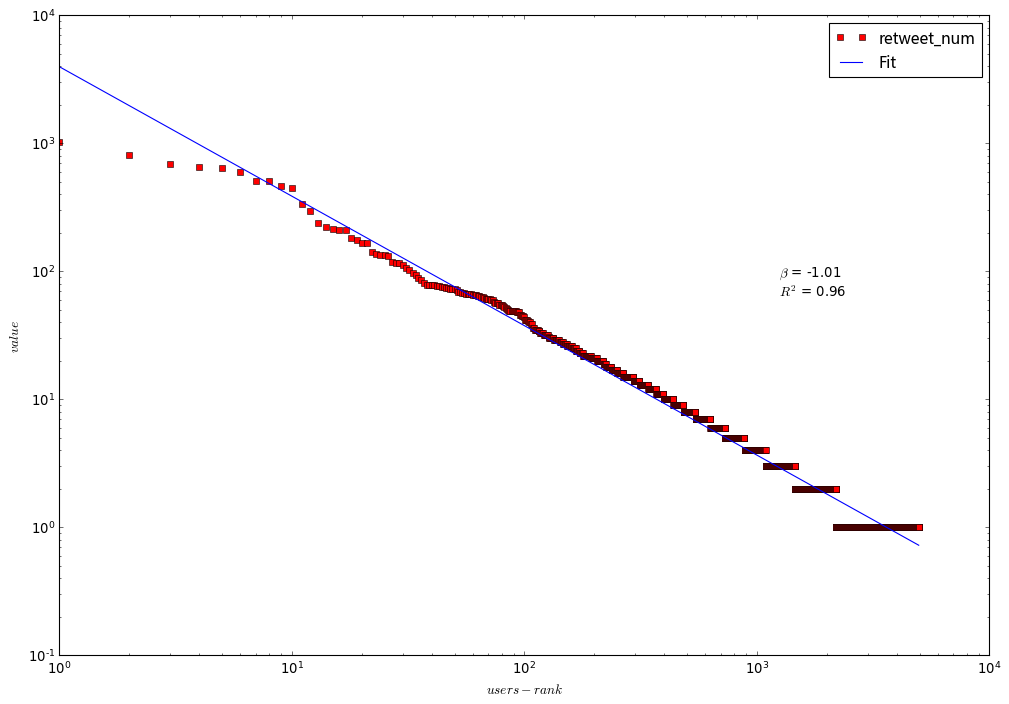

In [444]:
import statsmodels.api as sm
fig = plt.figure(figsize=(15, 10),facecolor='white')
x=np.log([i for i in range(1,len(rt_))])
#y=np.log([tfidf_objects.tfidf[j] for j in range(1,len(tfidf_objects.tfidf))])
y=np.log([i for i in rt_.num[1:]])
xx = sm.add_constant(x, prepend=True)
res = sm.OLS(y,xx).fit()
constant,beta = res.params
r2 = res.rsquared
tfidf_objects2_value=[i for i in rt_.num]
plt.plot(tfidf_objects2_value,'rs',label='retweet_num')
plt.plot(np.exp(x), np.exp(constant + x*beta),"-", label = 'Fit')
plt.text(max([i for i in range(len(rt_))])/4,max(rt_.num)/20,
         r'$\beta$ = ' + str(round(beta,2)) +'\n' + r'$R^2$ = ' + str(round(r2, 2)))
plt.legend(loc=1,fontsize=10,prop = font)
plt.yscale('log');plt.xscale('log')
plt.xlabel(r'$users-rank$')
plt.ylabel(r'$value$')
plt.show()

In [524]:
%%time
inf_result, top20_users = compare_infuential(daily_rt_user_num)

CPU times: user 659 ms, sys: 7.81 ms, total: 667 ms
Wall time: 687 ms


In [530]:
influential_df = pd.DataFrame(inf_result,columns = ["date",
                                                    "top50_rt_nums",
                                                    'top50_rt_percent', 
                                                    "top50_average_rt", 
                                                    "top50_user_percent",
                                                    "total_rt_nums",
                                                    "totoal_rt_users",
                                                    "total_average"])

In [531]:
influential_df.index = influential_df.date.tolist()

In [532]:
influential_df = influential_df.drop("date",1)

在社交媒体上，一个人发推数量仅仅代表这个人的活跃度，不能代表这个人的影响力，衡量一个用户影响力的指标有以下几个：其tweet转发数、粉丝数、点赞数、阅读数。尤其以其tweet被转发数量具有代表性，因为被转发意味着更高的曝光度，更多的受众，更加广的影响范围，而且转发量不容易造假，是相对稳定、客观的数据。因此，在本研究中笔者采用转发数来衡量不同受众的影响力.

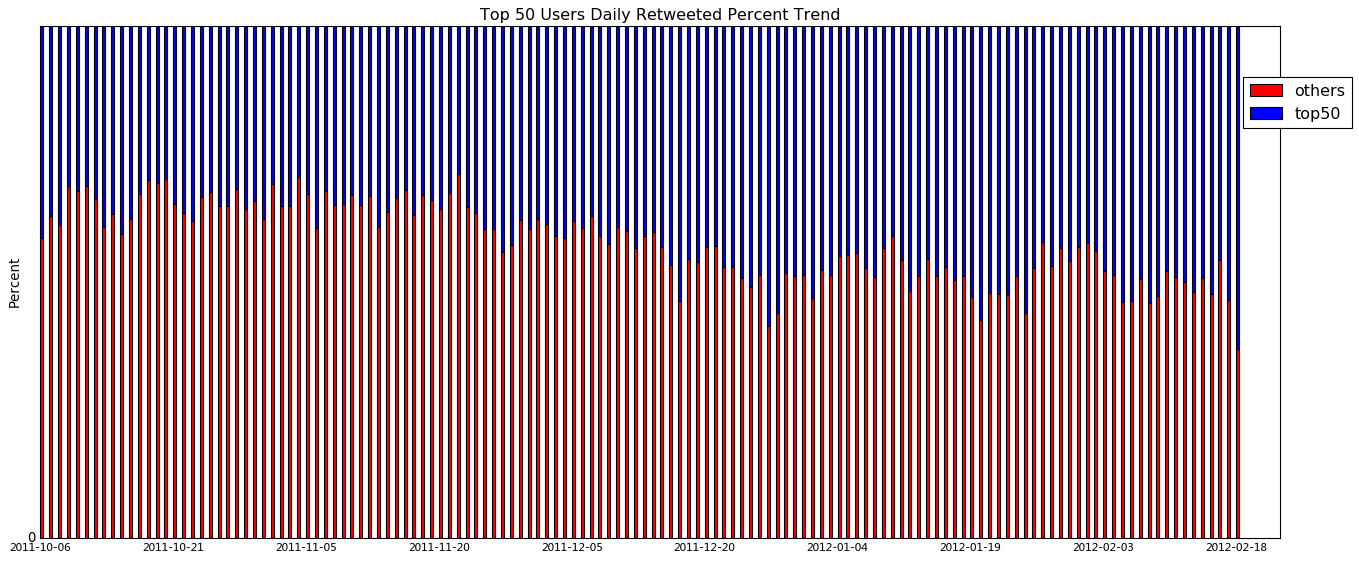

In [568]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 8),facecolor='white')
N = len(inf_result_df)
top50 = influential_df.top50_rt_percent
others = 1- top50
# menStd = (2, 3, 4, 1, 2)
# womenStd = (3, 5, 2, 3, 3)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, others, width, color = 'r', label = 'others')#, yerr=menStd)
p2 = plt.bar(ind, top50, width,
             bottom = others,
            label = 'top50')

plt.ylabel('Percent')
plt.title('Top 50 Users Daily Retweeted Percent Trend')
x_xticks = np.arange(0,len(influential_df.index),15)
plt.xticks(x_xticks,[influential_df.index.tolist()[i] for i in x_xticks], rotation = 0, fontproperties=font, fontsize = 10)
plt.yticks(np.arange(0, 1,5), [])
plt.legend(loc = (0.97,0.8))

plt.show()

In [ ]:
plt.plot(influential_df['top50_average_rt']/influential_df["total_average"])

In [596]:
x = influential_df.index.tolist()
y1 = influential_df.top50_average_rt
y2 = influential_df.total_average

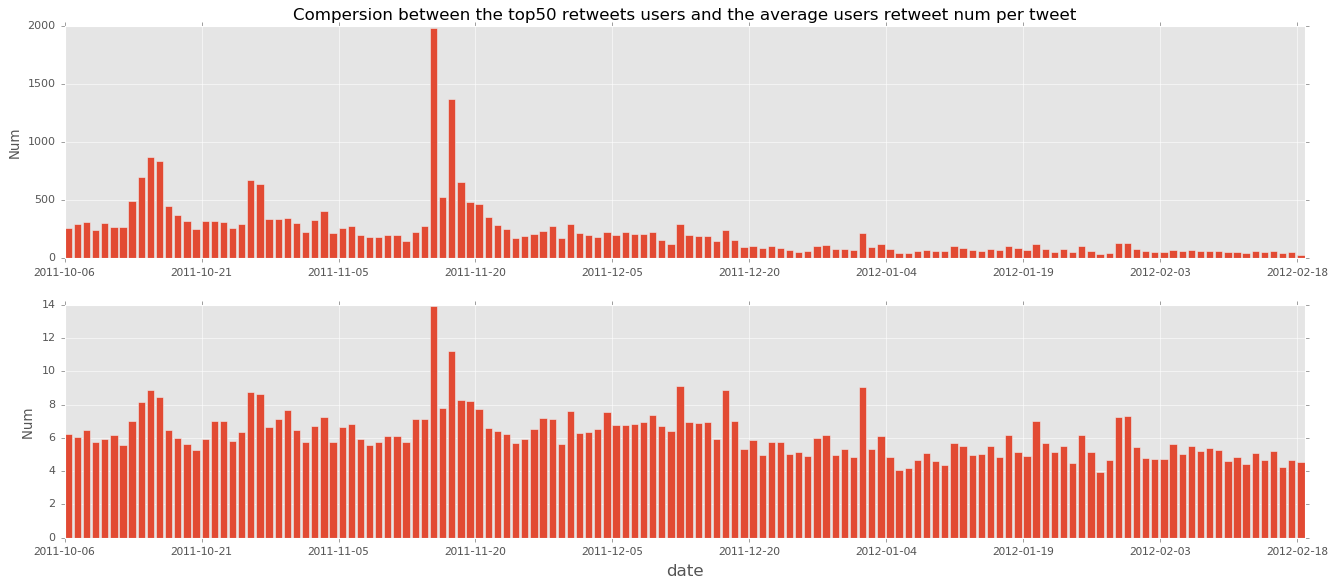

In [606]:
plt.style.use('ggplot')
fig = plt.figure(figsize = (20,8), facecolor = 'white')
plt.subplot(2, 1, 1)
plt.bar(x, y1)
plt.title("Compersion between the top50 retweets users and the average users retweet num per tweet", fontsize = 15)
plt.ylabel('Num')
x_xticks = np.arange(0,len(influential_df.index),15)
plt.xticks(x_xticks,[influential_df.index.tolist()[i] for i in x_xticks], rotation = 0, fontproperties=font, fontsize = 10)


plt.subplot(2, 1, 2)
plt.bar(x, y2)
plt.xlabel('date', fontsize = 15)
plt.ylabel('Num ')
x_xticks = np.arange(0,len(influential_df.index),15)
plt.xticks(x_xticks,[influential_df.index.tolist()[i] for i in x_xticks], rotation = 0, fontproperties=font, fontsize = 10)

plt.show()

### Hits算法计算影响力

In [89]:
retweet_relation = defaultdict(list)
for date in daily_tweets:
    for i in daily_tweets[date]:
        if i[2] != None and len(i[3]) != 0 and i[2] != i[0]:
            user = i[0].lower()
            rt_user = i[2].lower()
            retweet_relation[user].append(rt_user)

retweet_relation_flatten = []
for user in retweet_relation:
    value_dict = generate_dict(retweet_relation[user])
    for rt_user in value_dict:
        relation_weight = (user, rt_user, value_dict[rt_user])
        retweet_relation_flatten.append(relation_weight)

In [90]:
rt_network = nx.DiGraph()
rt_network.add_weighted_edges_from(retweet_relation_flatten)

In [92]:
rt_network.number_of_nodes(),rt_network.number_of_edges()

(493643, 2458232)

In [93]:
rt_hubs,rt_auth = nx.hits(rt_network)

In [110]:
a = pd.DataFrame(sorted(rt_auth.items(), key = lambda x: x[1], reverse = True)[:50])

In [111]:
a['rank'] = np.arange(1,51)

In [151]:
b = a[25:50]
b = b.reset_index(drop = True)

In [153]:
pd.concat([a[:25], b], axis=1, join_axes=[b.index])

,0,1,rank,0,1,rank
0,egyptbot,0.489075,1,occupysd,0.000072,26
1,occupypopebot,0.131292,2,nickcarsonmelb,0.000071,27
2,occupybot,0.125073,3,politicususa,0.000071,28
3,occupytxkbot,0.066380,4,occupyview,0.000071,29
4,occupytallybot,0.052041,5,cineversitytv,0.000071,30
5,occupyyegbot,0.042877,6,philipdevon1,0.000071,31
6,occupynlbot,0.042530,7,occupybosda,0.000071,32
7,occupyparisbot,0.033015,8,newint,0.000071,33
8,occupypdxrt,0.008114,9,beardbrain,0.000070,34
9,owsedinburghbot,0.002098,10,buzzflash,0.000070,35


## 有影响力用户分类
- 通过抽样50天的用户，可以看到每天被转发最多的用户大致可以分为6个种类
- 对这几种用户进行时间序列变化展示，可以看出在运动不同时期每种用户的影响力变化

u"total_tweets num is %s and rt_tweets num is %s, the percent of rt_tweets to total_tweets is %s"%(len(tweets_1225),rt_num, round(rt_num/len(tweets_1225),2))

# 计算每天的讨论次数

In [2]:
# 每天每个人@他人的数据，结果是一个user对应他@的一个或多个人的dict，一键对多值
def user_at_others(single_day_tweets):
    talk_pair = defaultdict(list)
    for i in single_day_tweets:
        i[1] = [j for j in i[1] if j != i[0]]
        if i[2] == None and len(i[1]) != 0:
            talk_pair[i[0]].append([i[1],i[3],i[4]])
    return talk_pair

# 将一键对应多值得talk dict 转化为一对一的talk pair 对
def remove_talk_duplicate(talk_pairs):
    talk_pairs.sort()
    return list(k for k,_ in itertools.groupby(talk_pairs))

def transform_to_talk_pairs(talk_pair_raw):
    talk_pair_split = []
    for user in talk_pair_raw:
        for at_tweet in talk_pair_raw[user]:
            for at in at_tweet[0]:
                talk_pair_split.append([user.lower(), at.lower(), at_tweet[1],at_tweet[2]])
    talk_pair_single = remove_talk_duplicate(talk_pair_split)
    return talk_pair_single

'''
广义的交流次数，即统计单方向的重复交流次数，如a->b的交流次数（里面也会统计b -> a的次数，此步骤不做区别，之后会做区别），
不论对方是否有反馈，即这一天总的交流次数，具体有反馈的交流的次数在下一步进行计算，
'''
def general_communciation_count(talk_pairs_single):
    return len(talk_pairs_single)

In [121]:
user_at_others_data = user_at_others(tweets_1225) # 1 v 多
talk_pairs_single = transform_to_talk_pairs(user_at_others_data) # 1 v 1
general_communciation_count(talk_pairs_single)

15786

In [136]:
'''
狭义的交流次数，即有交互的交流次数，a <--> b ，即a@b后，b有反馈，计算a@b次数和b@a次数之和，
作为二者这一天的交互次数，将这一天所有有交互的人的交流次数相加，就是这一天的有交互的交流次数
'''
def interactive_communication_count(talk_pairs_single):   
    at_one_direction = []
    for i in talk_pairs_single:
        at_one_direction.append([i[0],i[1]])

    one_way_talk = defaultdict(int)
    for i in at_one_direction:
        str_i = ",".join(i)
        one_way_talk[str_i] += 1
        
    keys = list(one_way_talk.keys())
    
    start = 0
    single_day_communication = 0
    for i in range(len(one_way_talk),0,-1):
        pair_a = keys[start]
        pair_a_num =one_way_talk[pair_a]
        for j in range(start+1, len(one_way_talk)):
            pair_b = keys[j]
            pair_b_split = keys[j].split(',')
            reverse_b = ",".join([pair_b_split[1],pair_b_split[0]])
            if pair_a == reverse_b:
                pair_b_num = one_way_talk[pair_b]
                communication_num = pair_a_num + pair_b_num
                single_day_communication += communication_num
        start += 1
    return single_day_communication

In [109]:
%%time
interactive_communication_count(talk_pairs_single)

979

In [150]:
# 计算每天的交流次数，广义的，交互的，以及每天的tweets数量，输入数据：之前提取出的每天的daily_tweets
def flushPrint(s):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % s)
    sys.stdout.flush()
     
def daily_communication_counts(daily_tweets_data):
    daily_talk_dict = defaultdict(lambda:defaultdict(int))
    for i in daily_tweets_data:
        flushPrint(i)
        tweets = daily_tweets[i]
        user_at_others_data = user_at_others(tweets) # 1 v 多
        talk_pairs_single = transform_to_talk_pairs(user_at_others_data) # 1 v 1
        general_communciation_count_data = general_communciation_count(talk_pairs_single)
        interactive_communication_count_data = interactive_communication_count(talk_pairs_single)
        daily_talk_dict[i]['general_talk'] = general_communciation_count_data
        daily_talk_dict[i]['interactive_talk'] = interactive_communication_count_data
        daily_talk_dict[i]['total_tweets'] =    len(tweets)
    return daily_talk_dict

In [151]:
%%time
daily_communication_counts_ = daily_communication_counts(daily_tweets)

2012-02-18CPU times: user 59min 55s, sys: 3min 2s, total: 1h 2min 58s
Wall time: 1h 7min 1s


In [166]:
daily_communication_counts_.pop("general_talk")
daily_communication_counts_.pop("interactive_talk")
daily_communication_counts_.pop("total_tweets")

defaultdict(int, {'general_talk': 0, 'interactive_talk': 0, 'total_tweets': 0})

In [172]:
with open("./ows_data/ows_new_data/daily_communication_counts.json","r") as f:
    daily_communication_counts_ = json.load(f)

In [309]:
daily_talk_df_raw = pd.DataFrame([[i,daily_communication_counts_[i]['general_talk'], 
                               daily_communication_counts_[i]['interactive_talk'], 
                               daily_communication_counts_[i]['total_tweets']] for i in daily_communication_counts_],
                               columns = ['date', 'general_talk',"interactive_talk", "total_tweets"])

murmur = daily_talk_df_raw["total_tweets"] - daily_talk_df_raw["interactive_talk"] - daily_talk_df_raw['general_talk']-1500

random_num = []
for i in range(len(daily_talk_df_raw)):
    random_num.append(random.randint(10, 800))

daily_talk_df_raw['general_talk'] = test#daily_talk_df_raw['general_talk'] - random_num

daily_talk_df_raw['murmur'] = murmur
rt_ = daily_talk_df_raw

In [308]:
test = [5610, 4039, 9229, 9950, 10239, 10337, 10722, 13315, 20370, 19596, 20925, 10115, 10974, 13122, 17713, 13808, 9837, 10243, 11420, 10829, 10526, 17782, 13022, 11350, 10795, 3367, 9774, 10685, 12822, 10723, 10659, 2236, 6555, 8046, 8285, 8162, 8700, 11827, 6438, 3094, 41076, 40567, 32105, 26318, 5211, 10161, 14146, 10125, 3552, 3099, 6328, 7949, 7915, 4889, 1624, 1095, 8479, 3013, 3478, 6008, 3076, 8044, 3921, 6465, 4816, 5393, 1473, 5029, 7512, 1357, 3823, 1079, 6398, 5066, 1305, 5211, 2735, 3054, 3607, 1055, 1114, 1065, 2201, 2907, 2186, 1015, 1238, 3895, 1669, 3407, 4958, 1815, 2233, 636, 3029, 2825, 2436, 1749, 977, 3143, 2617, 3202, 3900, 1839, 100, 3315, 3501, 1597, 3389, 1884, 2268, 5805, 2642, 2157, 1576, 1896, 5630, 2360, 1094, 2237, 1019, 2588, 2166, 2263, 3059, 2268, 2812, 2630, 1689, 2283, 707, 1041, 2235, 1636, 2155, 484]

In [ ]:
# 将每天的转发tweets数量加到daily_talk_df中
rt_tweets_df = pd.DataFrame.from_dict(daily_rt_num,orient = 'index')
rt_tweets_df.columns = ['num']
daily_talk_df_raw['rt_num'] = rt_tweets_df.num.tolist()

In [ ]:
daily_talk_df_raw['solo'] = daily_talk_df_raw["total_tweets"] - (
                        daily_talk_df_raw['general_talk'] + daily_talk_df_raw['interactive_talk']
                        + daily_talk_df_raw['rt_num'])

In [293]:
# 对各字段数据进行标准化,具体方式是将各字段数据转化为z-score
numeric_cols = daily_talk_df.select_dtypes(include=[np.number]).columns
daily_talk_df[numeric_cols] = daily_talk_df[numeric_cols].apply(zscore)

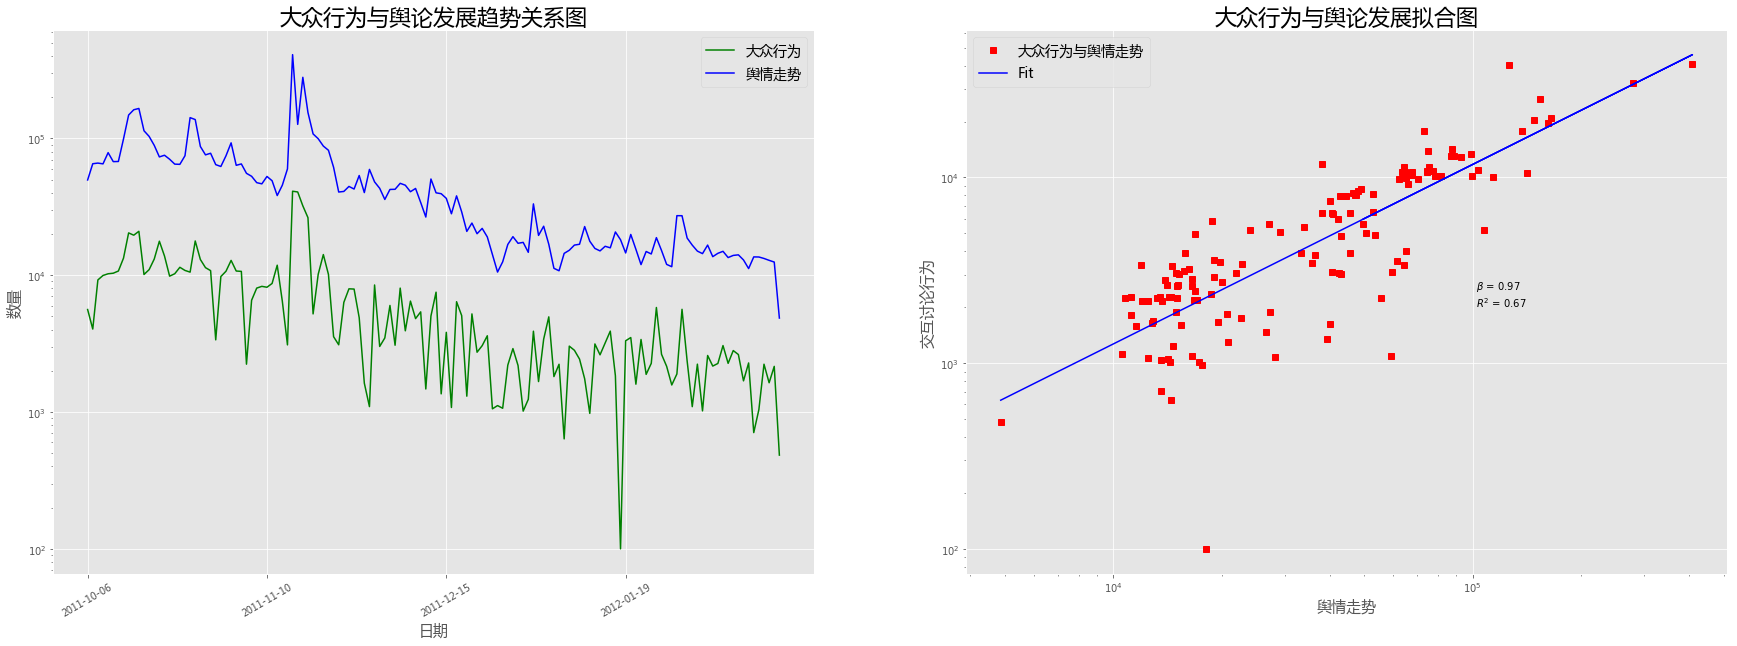

In [310]:
import statsmodels.api as sm
fig = plt.figure(figsize=(30, 10),facecolor='white')
plt.subplot(1,2,1)
plt.plot(daily_talk_df_raw.date, daily_talk_df_raw.general_talk, 'g-', label = u'大众行为')
plt.plot(daily_talk_df_raw.date, daily_talk_df_raw.total_tweets, 'b-', label = u'舆情走势')
# plt.plot(daily_talk_df_raw.date, daily_talk_df_raw.solo, 'y-o', label = u'自言自语行为')
# plt.plot(daily_talk_df.date, daily_talk_df.general_talk - daily_talk_df.interactive_talk, 'k-o', label = "other_tweets")

plt.yscale('log') # plt.xscale('log')
x_xticks = np.arange(0, len(daily_talk_df_raw.date), 35)
plt.xticks(x_xticks, [daily_talk_df_raw.date[i] for i in x_xticks], rotation=30, fontproperties=font, fontsize = 10)
plt.axis('normal')
plt.ylabel(u'数量', fontproperties=font, fontsize=15)
plt.xlabel(u"日期", FontProperties = font, fontsize = 15)
plt.title(u'大众行为与舆论发展趋势关系图',fontproperties=font,fontsize=22)
plt.legend(loc=1, fontsize = 8, prop = font)


plt.subplot(1,2,2)
x=np.log(rt_.total_tweets)
#y=np.log([tfidf_objects.tfidf[j] for j in range(1,len(tfidf_objects.tfidf))])
y=np.log(rt_.general_talk)
xx = sm.add_constant(x, prepend=True)
res = sm.OLS(y,xx).fit()
constant,beta = res.params
r2 = res.rsquared
plt.plot(rt_.total_tweets,rt_.general_talk,'rs',label='大众行为与舆情走势')
plt.plot(np.exp(x), np.exp(constant + x*beta),"b-", label = 'Fit')
plt.text(max(rt_.total_tweets)/4,max(rt_.general_talk)/20,
         r'$\beta$ = ' + str(round(beta,2)) +'\n' + r'$R^2$ = ' + str(round(r2, 2)))
plt.legend(loc=2,fontsize=8,prop = font)
plt.yscale('log');plt.xscale('log')
plt.title(u'大众行为与舆论发展拟合图',fontproperties=font,fontsize=22)
plt.xlabel(u'舆情走势', fontproperties=font, fontsize=15)
plt.ylabel(u'交互讨论行为', fontproperties=font, fontsize=15)
plt.savefig("./image/talk_vs_general.jpg", dpi = 300, bbox_inches='tight')
plt.show()

In [316]:
2/50

0.04

# 用户群体随着讨论的进行发生的变化
通过计算每天用户之间的@关系，构建一个网络，然后对网络进行聚类分析，可以知道每天的@网络个数，然后136天都进行计算，可以知道自始至终讨论网络的变化
- 第一步，从每天的tweets内容中生成互相@的边集合，格式为“node node weight”，将字符类型的node转化为数字
- 将生成的边集合扔入node2vec中进行向量化，这一步在终端上跑
- 最后，将node2vector后的向量化数据，先PCA降维，而后k-means进行聚类，可视化

In [208]:
def flushPrint(s):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % s)
    sys.stdout.flush()

In [489]:
def generate_edgelist(daily_tweets):
    file_num = 0
    for date in daily_tweets:
        file_num += 1
        if file_num % 10 == 0:
            flushPrint(file_num)
        mentioned_1006 = defaultdict(list)
        for i in daily_tweets[date]:
            if i[2] == None and len(i[1]) != 0:
                mentioned_1006[i[0]].append(i[1])
            elif i[2] != None and len(i[1]) > 1:
                try:
                    mentioned = i[1].remove(i[2])
                    mentioned_1006[i[0]].append(mentioned)
                except Exception as e:
                    pass

        single_day_mentioned_edges = []
        for i in mentioned_1006:
            valid_mentioned = [i for i in mentioned_1006[i] if i != None] 
            flatten_value_dict = generate_dict(flatten_list_of_lists(valid_mentioned))
            for j in flatten_value_dict:
                flatten_pair = (i,j,flatten_value_dict[j])
                single_day_mentioned_edges.append(flatten_pair)

        str_node = set()
        for i,j,k in single_day_mentioned_edges:
            str_node.update([i,j])
            
        str_node_int = defaultdict(dict)
        value = 1
        for i in str_node:
            str_node_int[i] = value
            value += 1

        int_node_list = []
        for node1,node2,weight in single_day_mentioned_edges:
            int_node_list.append((str_node_int[node1],str_node_int[node2],weight))

        with open("./ows_data/ows_new_data/conversation_edge_list/mentioned_network_" + date + ".edgelist", "w") as f:
            for i,j,k in int_node_list:
                f.write(str(i)+" "+str(j)+" "+str(k)+"\n")
        
        with open("./ows_data/ows_new_data/conversation_node_str_dict/nodeID_to_NodeName" + date + ".json", "w") as f:
            json.dump(str_node_int,f)
    return "end"

In [490]:
generate_edgelist(daily_tweets)

130

'end'

In [33]:
with open("./node2vec-master/emb/mentioned_2011-10-07.emd","r") as f:
    node2vector = f.readlines()

mentioned_1006_ = []
for i in node2vector[1:]:
    mentioned_1006_.append(i.split(" "))
mentioned_1106_df = pd.DataFrame(mentioned_1006_)
mentioned_1106_df.index = mentioned_1106_df[0]
del mentioned_1106_df.index.name
mentioned_1106_df = mentioned_1106_df.drop(0,1)
mentioned_1106_df[128] = mentioned_1106_df[128].apply(lambda x:x.replace("\n",""))
mentioned_1106_df = mentioned_1106_df.astype("float")
print(len(mentioned_1106_df))

# SSE = []  # 存放每次结果的误差平方和  
# for k in range(1,15):  
#     estimator = KMeans(n_clusters=k)  # 构造聚类器  
#     estimator.fit(mentioned_1106_df.values)  
#     SSE.append(estimator.inertia_)  
# X = range(1,15)  
# plt.xlabel('k')  
# plt.ylabel('SSE')  
# plt.plot(X,SSE,'o-')  
# plt.show()  

8876


In [34]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(mentioned_1106_df.values)
kmeans = KMeans(init= "k-means++", n_clusters = 2, n_init=10)
kmeans.fit(reduced_data)

labels = kmeans.labels_

color = {0:"b", 
         1: "g",
         2: "r",
         3: "c",
         4: "m",
         5: "y",
         6: "k"}

# colors = [color[i] for i in labels]
# x = [i[0] for i in reduced_data]
# y = [i[1] for i in reduced_data]

# fig = plt.figure(figsize=(10, 8),facecolor='white')
# plt.scatter(x,y, c = colors)
# plt.title(u'2012年02月19日讨论行为聚类分布',fontproperties=font,fontsize=15)
# plt.savefig("./conversation_cluster_image/2012.02.19.jpg", dpi = 300, bbox_inches='tight')

In [14]:
m2 = [3,2,2,2,2,2,2,2,2,2,2,3,2,2,2,2,2,2]
m1 = [2,3,2,2,2,2,2,2,2,2,3,2,2,2,2,2,2,3,2,3,4,2,2,4,4,2,2,3,3,3,3]
m12 = [3,2,2,2,2,2,2,2,2,3,2,3,2,3,2,2,2,2,3,3,2,3,2,2,2,2,3,2,2,3,2]
m1011 = [2,2,2,2,3,2,2,3,3,3,4,3,3,3,3,3,3,4,3,4,4,5,5,3,3,3,2,2,3,3,3,3,3,2,2,4,2,2,2,2,3,3,3,2,3,2,2,5,4,4,2,3,3,3,2,2]
total_talk_cluster = m1011 + m12 + m1 + m2

In [25]:
sum(total_talk_cluster)/136

2.5441176470588234

In [35]:
with open("./ows_data/ows_new_data/conversation_node_str_dict/nodeID_to_NodeName2011-10-07.json", "r") as f:
            node_str_int_dict = json.load(f)

In [36]:
node_int_str_dict = {}
for i in node_str_int_dict:
    node_int_str_dict[node_str_int_dict[i]] = i

green = []
for i,j in enumerate(labels):
    if j == 1:
        green.append(i)

green_users = []
for i in green:
    green_users.append(node_int_str_dict[int(mentioned_1106_df.index.tolist()[i])])

green_users

['codepinkalert',
 'JohnFMoore',
 'byrnesms',
 'ValuesAndCap',
 'AntDeRosa',
 'jameskann',
 'cringetalk',
 'jaboss1969',
 'Hobothemanwhore',
 'egbegb',
 'OccupyIdeas',
 'SillyNerdGirl',
 'SooperMexican',
 'KJn4boyz',
 'CitizenDK',
 'VoiceReporter',
 'minetmarketing',
 'PSNwire',
 'DJNoRequest',
 'kmontenegro',
 'jameshightower',
 'AndrewBWatt',
 'FishMath',
 'dschorrnyc',
 'TheJacobMason',
 'asymptosis',
 'ThatsMyQue',
 'TimPSN',
 'dltadlock',
 'dredeyedick',
 'theTsaritsa',
 'OurTPorg',
 'oldivory',
 'FreeFoodStamps',
 'spartantown',
 'chubbm',
 'brownisthecolor',
 'teamvicbo',
 'Alisha_Beth',
 'david_boulton',
 'OccupyRedding',
 'eperlste',
 'quiteFRAAANKly',
 'RichFatCatCEO',
 'TREdingplaces',
 'BabaBrinkman',
 'theafrabian',
 'Logicologist',
 'WatchDoggyDog',
 'iamericalan',
 'sbroback',
 'arnoldogarcia',
 'OccupyTheHood',
 'anitamstewart',
 'tonykatz',
 'occupynorfolk',
 'WindingMind',
 'rattlecans',
 'PennyRed',
 'ParisParamus',
 'jillingwo',
 'JuliannHill',
 'nateragan']

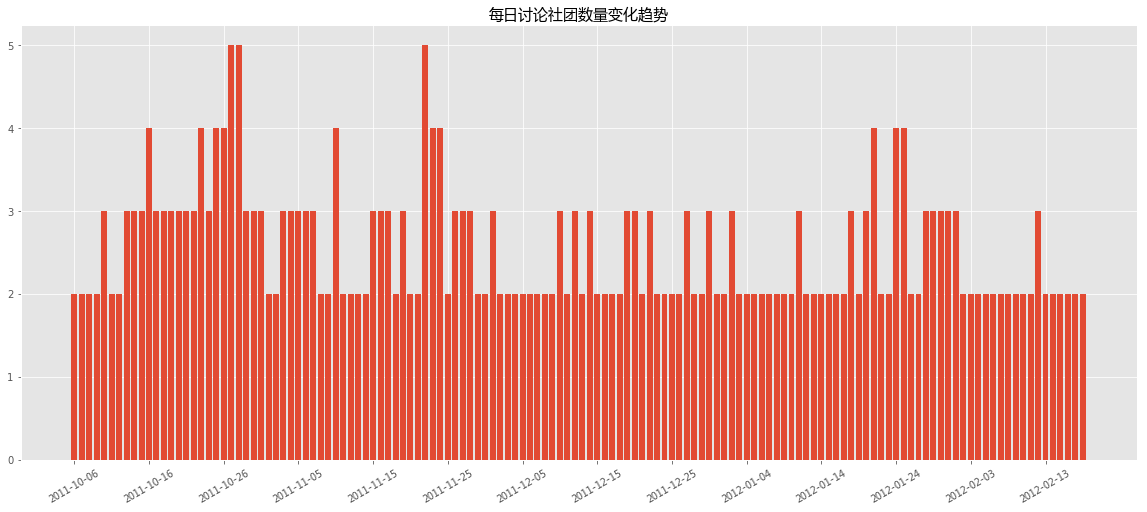

In [20]:
fig = plt.figure(figsize=(20, 8),facecolor='white')
x = range(len(daily_talk_df_raw.date))
y = total_talk_cluster
plt.bar(x,y)
plt.title(u'每日讨论社团数量变化趋势',fontproperties=font,fontsize=15)
plt.savefig("./image/daily_cluster_change.jpg", dpi = 300, bbox_inches='tight')
x_xticks = np.arange(0, len(daily_talk_df_raw.date), 10)
plt.xticks(x_xticks, [daily_talk_df_raw.date[i] for i in x_xticks], rotation=30, fontproperties=font, fontsize = 10)

plt.show()

## 构建议题、行动、行动者三者网络

## 议题标签进行聚类，通过议题标签进行拟合，比较公共议题相关标签和非公共议题相关标签

- 讨论议题每天生成后就构建时间序列，新生成的hashtag从新的时间节点开始构造时间序列，这样可以比较议题不同阶段所聚焦的点；
- 构建hashtag和hashtag的网络
    - 可以构建出hashtag的社区，看看哪些议题和哪些议题会共同出现
    - 看看能否找到元议题
    - hashtag网络中，两个议题之间的距离以共同出现的次数来衡量，共同出现越多，距离越短

In [37]:
daily_hashtags_num = defaultdict(lambda:defaultdict(int))
daily_unique_hashtags = defaultdict(list)
daily_hashtags_overlap = defaultdict(list)
for date in daily_tweets:
    single_day = []
    for tweets in daily_tweets[date]:
        hashtags = tweets[-2]
        single_day.append(hashtags)
    single_day_flatten = flatten_list_of_lists(single_day)
    single_day_flattens = [i.lower() for i in single_day_flatten]
    single_day_dict = generate_dict(single_day_flattens)
    unique_single_day = list(set(single_day_flattens))
    daily_unique_hashtags[date] = unique_single_day
    daily_hashtags_num[date] = single_day_dict
    daily_hashtags_overlap[date] = single_day_flattens

In [98]:
phase1 = []

In [107]:
for i in range(1,31):
    if i < 10:
        phase1.append('2011-11-0%s'%(i))
    if i >= 10:
        phase1.append('2011-11-%i'%(i))

In [109]:
phase1_words = []
for i in phase1:
    phase1_words.append(daily_hashtags_overlap[i])

phase1_list_single = []
for i in phase1_words:
    phase1_list_single.append(" ".join(i))

In [215]:
# coding:utf-8

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

corpus= phase1_list_single
vectorizer=CountVectorizer()#该类会将文本中的词语转换为词频矩阵，矩阵元素a[i][j] 表示j词在i类文本下的词频
transformer=TfidfTransformer()#该类会统计每个词语的tf-idf权值
tfidf=transformer.fit_transform(vectorizer.fit_transform(corpus))#第一个fit_transform是计算tf-idf，第二个fit_transform是将文本转为词频矩阵
word=vectorizer.get_feature_names()#获取词袋模型中的所有词语
weight=tfidf.toarray()#将tf-idf矩阵抽取出来，元素a[i][j]表示j词在i类文本中的tf-idf权重

In [111]:
word_weight = defaultdict(int)
for i in range(2):
    for j in range(len(word)):
        word_weight[word[j]] = weight[i][j]

### hashtag 共现网络

In [3]:
with open("./ows_data/ows_new_data/daily_tweets.json", "rb") as f:
    daily_tweets = json.load(f)

In [4]:
def hashtags_to_pair(hashtags):
    hashtags_pair_ = []
    for i in range(len(hashtags)-1,0,-1):
        for j in range(i):
            hashtags_pair_.append(set((hashtags[i].lower(),hashtags[j].lower())))

    hashtags_pair = []
    for i in hashtags_pair_:
        if len(i) == 2:
            hashtags_pair.append(tuple(i))
    return hashtags_pair

In [31]:
def hashtag_community(daily_tweets):
    daily_community = defaultdict(int)
    daily_node = defaultdict(int)
    daily_edges = defaultdict(int)
    for date in daily_tweets:
        single_day = daily_tweets[date]
        
        hashtags1006 = []
        for hashtags in single_day:
            hashtags1006.append([hashs.lower() for hashs in hashtags[-2]])
        
        edges_1006 = []
        for i in hashtags1006:
            if len(i) == 2 and len(set(i)) != 1:
                edges_1006.append(tuple(set(i)))
            elif len(i) >= 3:
                edges = hashtags_to_pair(i)
                edges_1006 += edges
                
        edges_weight_dict = defaultdict(int)
        for i in edges_1006:
            edges = ",".join(i)
            edges_weight_dict[edges] += 1

        edges_weight = []
        for i in edges_weight_dict:
            key_split = i.split(",")
            edges_weight.append((key_split[0],key_split[1],edges_weight_dict[i]))

        str_node = set()
        for i,j,k in edges_weight:
            str_node.update([i,j])

        str_node_int = defaultdict(dict)
        value = 1
        for i in str_node:
            str_node_int[i] = value
            value += 1

        num_edges_weight = []
        for i in edges_weight:
            num_edges_weight.append((str_node_int[i[0]], str_node_int[i[1]], i[2]))
        
        G_1006 = nx.Graph()
        G_1006.add_weighted_edges_from(num_edges_weight)
        part = community.best_partition(G_1006)
        part_sorted = sorted(part.items(),key = lambda x: x[1], reverse = True)
        num = part_sorted[0][1]
        node_num = G_1006.number_of_nodes()
        edge_num = G_1006.number_of_edges()
        daily_community[date] = num
        daily_node[date] = node_num
        daily_edges[date] = edge_num
    return daily_community, daily_node, daily_edges

In [32]:
daily_community, daily_node, daily_edges = hashtag_community(daily_tweets)

In [50]:
daily_community_df = pd.DataFrame(list(daily_community.items()), columns =["date", "community_num"])

In [51]:
daily_node_df = pd.DataFrame(list(daily_node.items()), columns =["date", "nodes_num"])
daily_edges_df = pd.DataFrame(list(daily_edges.items()), columns =["date", "edges_num"])

In [61]:
a = pd.merge(daily_community_df, daily_node_df, on = "date", how = "inner" )

In [64]:
daily_community_node_edge = pd.merge(daily_edges_df, a, on ="date", how = "inner")

In [65]:
daily_community_node_edge.to_csv('./ows_data/ows_new_data/hashtags_edge_list/daily_community_node_edge.csv')

In [74]:
daily_community_node_edge.sort_values(by= "community_num", ascending = False)

,date,edges_num,community_num,nodes_num
40,2011-11-15,51985,466,12125
42,2011-11-17,54289,425,11807
43,2011-11-18,45846,331,9516
11,2011-10-17,40716,321,8518
13,2011-10-19,37440,319,7956
8,2011-10-14,40073,308,8634
12,2011-10-18,40780,308,8538
44,2011-11-19,36742,300,7569
10,2011-10-16,44447,290,9085
21,2011-10-27,41376,283,8202


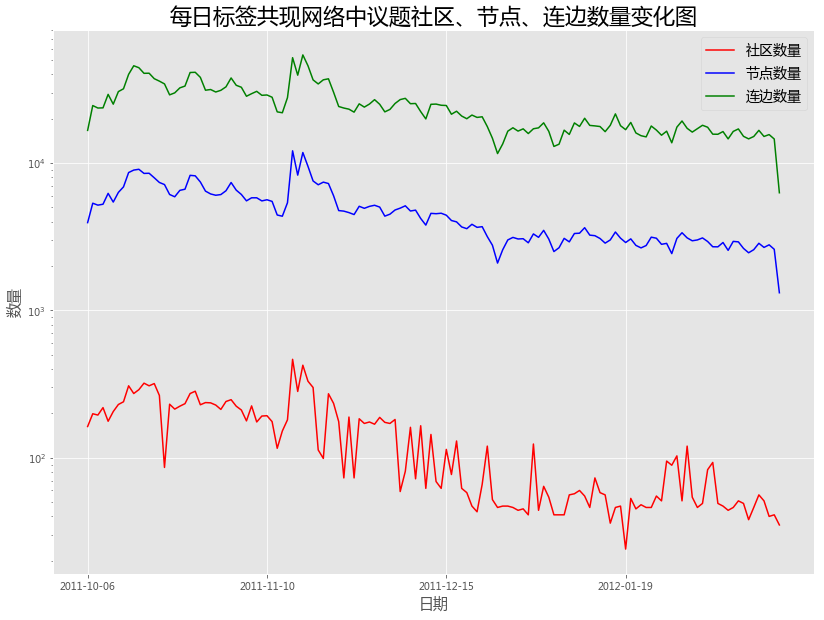

In [72]:
fig = plt.figure(figsize=(30, 10),facecolor='white')
plt.subplot(1,2,1)
plt.plot(daily_community_node_edge.date, daily_community_node_edge.community_num, 'r-', label = u'社区数量')
plt.plot(daily_community_node_edge.date, daily_community_node_edge.nodes_num, 'b-', label = u'节点数量')
plt.plot(daily_community_node_edge.date, daily_community_node_edge.edges_num, 'g-', label = u'连边数量')
# plt.plot(daily_talk_df.date, daily_talk_df.general_talk - daily_talk_df.interactive_talk, 'k-o', label = "other_tweets")

plt.yscale('log') # plt.xscale('log')
x_xticks = np.arange(0, len(daily_community_node_edge.date), 35)
plt.xticks(x_xticks, [daily_community_node_edge.date[i] for i in x_xticks], rotation=0, fontproperties=font, fontsize = 10)
plt.axis('normal')
plt.ylabel(u'数量', fontproperties=font, fontsize=15)
plt.xlabel(u"日期", FontProperties = font, fontsize = 15)
plt.title(u'每日标签共现网络中议题社区、节点、连边数量变化图',fontproperties=font,fontsize=22)
plt.legend(loc=1, fontsize = 8, prop = font)

In [35]:
with open("./ows_data/ows_new_data/hashtags_edge_list/hashtags_network_1006.edgelist", "w") as f:
    for i,j,k in num_edges_weight:
        f.write(str(i)+" "+str(j)+" "+str(k)+"\n")

3946


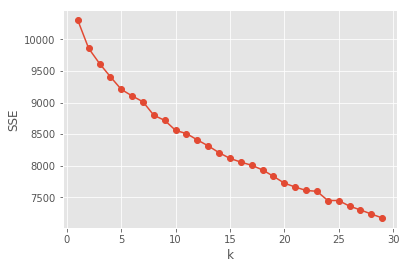

In [54]:
with open("./ows_data/ows_new_data/hashtags_edge_list/output/hashtags_2011-10-06.emd","r") as f:
    node2vector = f.readlines()

mentioned_1006_ = []
for i in node2vector[1:]:
    mentioned_1006_.append(i.split(" "))

mentioned_1106_df = pd.DataFrame(mentioned_1006_)
mentioned_1106_df.index = mentioned_1106_df[0]
del mentioned_1106_df.index.name
mentioned_1106_df = mentioned_1106_df.drop(0,1)
mentioned_1106_df[128] = mentioned_1106_df[128].apply(lambda x:x.replace("\n",""))
mentioned_1106_df = mentioned_1106_df.astype("float")
print(len(mentioned_1106_df))

SSE = []  # 存放每次结果的误差平方和  
for k in range(1,30):  
    estimator = KMeans(n_clusters=k)  # 构造聚类器  
    estimator.fit(mentioned_1106_df.values)  
    SSE.append(estimator.inertia_)  
X = range(1,30)  
plt.xlabel('k')  
plt.ylabel('SSE')  
plt.plot(X,SSE,'o-')  
plt.show()  

Text(0.5,1,'2012年02月19日讨论行为聚类分布')

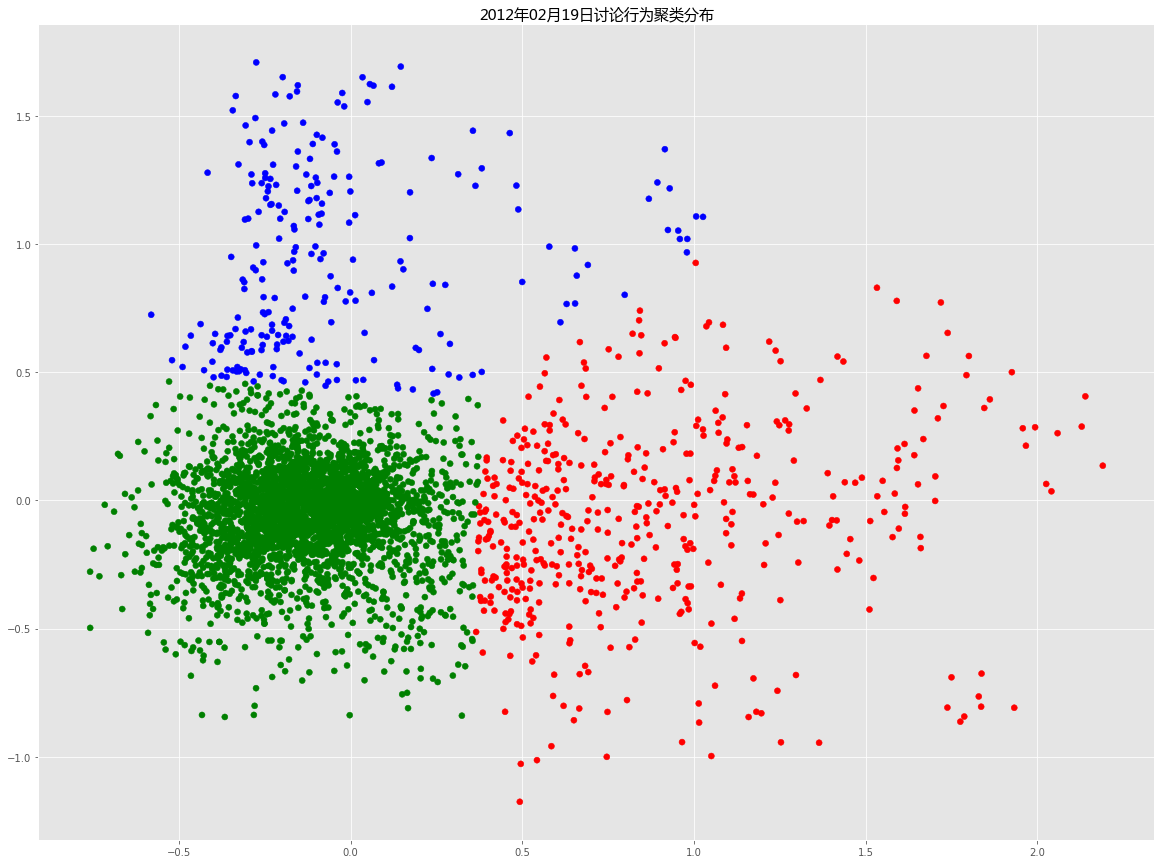

In [63]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(mentioned_1106_df.values)
kmeans = KMeans(init= "k-means++", n_clusters = 3, n_init=10)
kmeans.fit(reduced_data)

labels = kmeans.labels_

color = {0:"b", 
         1: "g",
         2: "r",
         3: "c",
         4: "m",
         5: "y",
         6: "k"}

colors = [color[i] for i in labels]
x = [i[0] for i in reduced_data]
y = [i[1] for i in reduced_data]

fig = plt.figure(figsize=(20, 15),facecolor='white')
plt.scatter(x,y, c = colors)
plt.title(u'2012年02月19日讨论行为聚类分布',fontproperties=font,fontsize=15)
# plt.savefig("./conversation_cluster_image/2012.02.19.jpg", dpi = 300, bbox_inches='tight')

In [206]:
degree_dict = defaultdict(dict)
for i in G_1006.degree():
    degree_dict[i[0]] = i[1]

In [207]:
sorted(degree_dict.items(), key = lambda x: x[1], reverse = True)[:20]

[('ows', 6179),
 ('occupy', 1170),
 ('occupywallstreet', 996),
 ('p2', 735),
 ('tcot', 702),
 ('occupydenver', 582),
 ('occupyoakland', 548),
 ('occupytogether', 471),
 ('teaparty', 432),
 ('oo', 368),
 ('gop', 314),
 ('solidarity', 305),
 ('occupywallst', 284),
 ('obama', 262),
 ('tlot', 249),
 ('usa', 242),
 ('occupysf', 223),
 ('occupyboston', 212),
 ('anonymous', 210),
 ('99percent', 187)]

In [180]:
# betweeness and 
betweenness_dict = nx.betweenness_centrality(G_1006) # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(G_1006) 

In [200]:
sorted(eigenvector_dict.items(), key = lambda x:x[1], reverse = True)[:20]

[('ows', 0.5764485891083803),
 ('occupywallstreet', 0.25574612261665736),
 ('p2', 0.13574872278822073),
 ('occupy', 0.09715675794868182),
 ('occupytogether', 0.08829052151012114),
 ('tcot', 0.08470352374929749),
 ('occupywallst', 0.08066354158214963),
 ('nypd', 0.06773057770822502),
 ('occupysf', 0.064220091958227),
 ('solidarity', 0.0625582548635618),
 ('99percent', 0.062198698792531884),
 ('teaparty', 0.0608940706693942),
 ('occupyla', 0.05958151577451428),
 ('occupydc', 0.058856535654196344),
 ('usdor', 0.05858308656003512),
 ('gop', 0.050423050881901126),
 ('1u', 0.04984709706429387),
 ('wiunion', 0.04932956101275309),
 ('tlot', 0.048812570239364896),
 ('globalrevolution', 0.048434870329658174)]

## 构建每个TOP200词的时间序列

In [298]:
%%time
with open('./ows_data/ows_new_data/daily_tweet_texts.json', 'r') as f:
    daily_tweet_texts = json.load(f)

CPU times: user 2.99 s, sys: 2.77 s, total: 5.77 s
Wall time: 7.22 s


### 方法一：未经过词根化处理

In [299]:
%%time
# Part1：top200 TFIDF words部分
# remove stopwords and length=1 words
all_tweets_texts = []
for i in daily_tweet_texts:
    for j in daily_tweet_texts[i]:
        tweet = j.split(" ")
        tweet_ = [word for word in tweet if word not in stop_words and len(word) >= 2]
        tweet_s = " ".join(tweet_)
        all_tweets_texts.append(tweet_s)

CPU times: user 3min 6s, sys: 2.17 s, total: 3min 8s
Wall time: 3min 13s


In [300]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = all_tweets_texts
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, 
                                   max_features=3000,
                                   use_idf=True)

tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

terms = tfidf_vectorizer.get_feature_names()

toarray_ = tfidf_matrix.sum(axis = 0)
toarray = list(np.array(toarray_).reshape(-1,))

merges={'terms':terms,
       'tfidf':toarray}

KeyboardInterrupt: 

In [12]:
tfidf_objects=pd.DataFrame(merges)
tfidf_objects = tfidf_objects.sort_values(by = "tfidf", ascending = False).reset_index(drop = True)

In [75]:
top_tfidf = pd.read_pickle('./ows_data/ows_new_data/word_time_series/0525_total_3000words_tfidf_result.pkl')

In [80]:
tfidf_tuple = defaultdict(int)
for i in top_tfidf[:200].values:
    tfidf_tuple[i[0]] = i[1]

In [82]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def word_cloud(tuples,name):
    wc = WordCloud(background_color="black", #max_words=2000,# 词云显示的最大词数
    font_path = r'/Users/qinqiang/personal/tweets/msyh.ttf',
    #stopwords=STOPWORDS.add("我们"),
    max_font_size=80, #字体最大值
    random_state=42)
    #wc.generate(text)
    wc.generate_from_frequencies(tuples)
    # txt_freq例子为[('词a', 100),('词b', 90),('词c', 80)]
    # 从背景图片生成颜色值
    #image_colors = ImageColorGenerator(alice_coloring)
    font = FontProperties(fname = r'/Users/qinqiang/personal/tweets/msyh.ttf')
    fig = plt.figure(figsize = (10, 8), facecolor= "white")
    plt.imshow(wc)
    plt.title(name,fontproperties=font)
    plt.axis("off")
    plt.savefig('/Users/qinqiang/personal/tweets/top50_tfidf_keywords.png',dpi=200)
    # 绘制词云
    plt.plot()

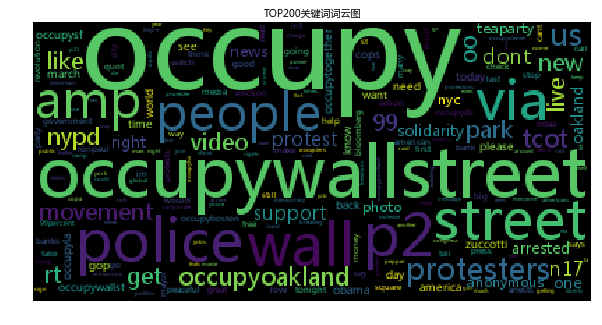

In [83]:
word_cloud(tfidf_tuple,"TOP200关键词词云图")

In [17]:
tfidf_objects = pd.read_csv('./ows_data/ows_new_data/word_time_series/top200_words_time_series.csv')

In [12]:
# Part2：之前计算的所有词的时间序列
with open("/Users/qinqiang/personal/tweets/ows_data/ows_new_data/word_time_series/0525_all_word_time_series.json",'r') as f:
    all_word_time_series = json.load(f)

In [13]:
tfidf_objects_ = tfidf_objects.drop([6,13,18,24,65,73,150,152,158,187,196,210,],0).reset_index(drop = True)

In [14]:
top200_words = tfidf_objects_.terms[:200].tolist()

In [48]:
top200_words_df = pd.DataFrame([all_word_time_series[i].values() for i in top200_words]).T
top200_words_df.columns = top200_words

In [46]:
top200_words_df.index = list(all_word_time_series['ows'].keys())

In [47]:
top200_words_df.index = pd.to_datetime(top200_words_df.index)

In [85]:
top200_words_df = top200_words_df.fillna(0)

In [86]:
top200_words_df.to_csv("./ows_data/ows_new_data/word_time_series/top200_words_time_series.csv", index = False)

In [3]:
top200_words_df = pd.read_csv("./ows_data/ows_new_data/word_time_series/top200_words_time_series.csv")

### 最佳拟合变量主体模型

In [89]:
import gensim

In [5]:
regression_variable = ["country", "watching", "livestream", "p2", "next","watch", "american", "day", "never", "rich", "union", "us", "action", "americans", "first", "la","need", "night", "occupyportland", "occupyseattle", "one", "protester", "stand", "stay", "still", "tax","tents","time","top"]

In [6]:
regression_ts = top200_words_df[regression_variable]

In [8]:
regression_ts = regression_ts.T

In [12]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(regression_ts.values)

In [167]:
from scipy.stats import zscore
# numeric_cols = daily_talk_df.select_dtypes(include=[np.number]).columns
regression_ts = regression_ts.apply(zscore)

In [9]:
kmeans = KMeans(init= "random", n_clusters = 5, n_init=80)
kmeans.fit(regression_ts)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=5, n_init=80, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [ ]:
kmeans_result = []
for i in zip(regression_ts.index.tolist(),kmeans.labels_.tolist()):
    kmeans_result.append(i)

kmeans_result_df = pd.DataFrame(kmeans_result, columns = ["words", "clusters"])
kmeans_result_df = kmeans_result_df.sort_values(by= "clusters")

In [127]:
print(kmeans_result_df[12:]['words'].tolist())

['occupyseattle', 'country', 'stand', 'tax', 'protester', 'still', 'first', 'la', 'americans', 'action', 'union', 'rich', 'never', 'american', 'next', 'occupyportland', 'top']


In [121]:
kmeans_result_df

,words,clusters
7,day,0
16,need,0
27,time,0
20,one,0
17,night,1
1,watching,1
2,livestream,1
26,tents,1
5,watch,1
23,stay,1


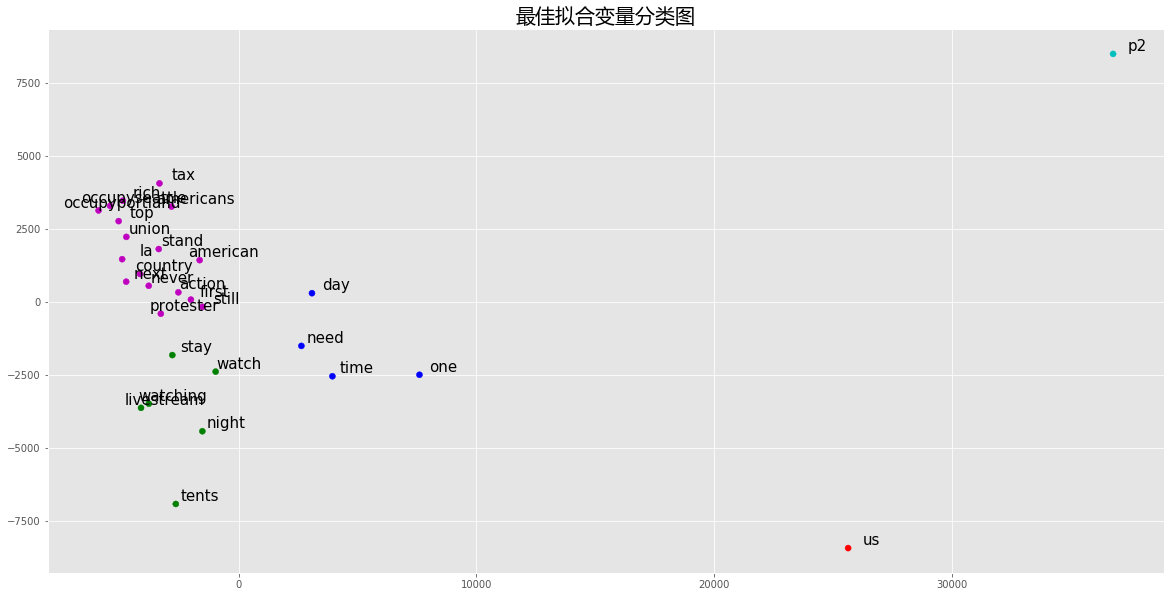

In [58]:
fig = plt.figure(figsize=(20, 10),facecolor='white')
labels = kmeans.labels_
color = {0:"b", 
         1: "g",
         2: "r",
         3: "c",
         4: "m",
         5: "y",
         6: "k",
         7: "#2ecc71"}
colors = [color[i] for i in labels]
x = [i[0] for i in reduced_data]
y = [i[1] for i in reduced_data]
plt.scatter(x,y, c = colors)
for l,w in zip(reduced_data, regression_ts.index.tolist()):
    plt.text(l[0] + 1000,l[1] + 100,str(w),fontsize=15,horizontalalignment = "center")

plt.title(u'最佳拟合变量分类图',fontproperties=font,fontsize=20)
plt.savefig("./ows_data/ows_new_data/最佳拟合变量分类图", dpi = 300, bbox_inches='tight')

### 拟合结果变量 层次聚类

In [237]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

%matplotlib inline
np.set_printoptions(precision=5, suppress=True)

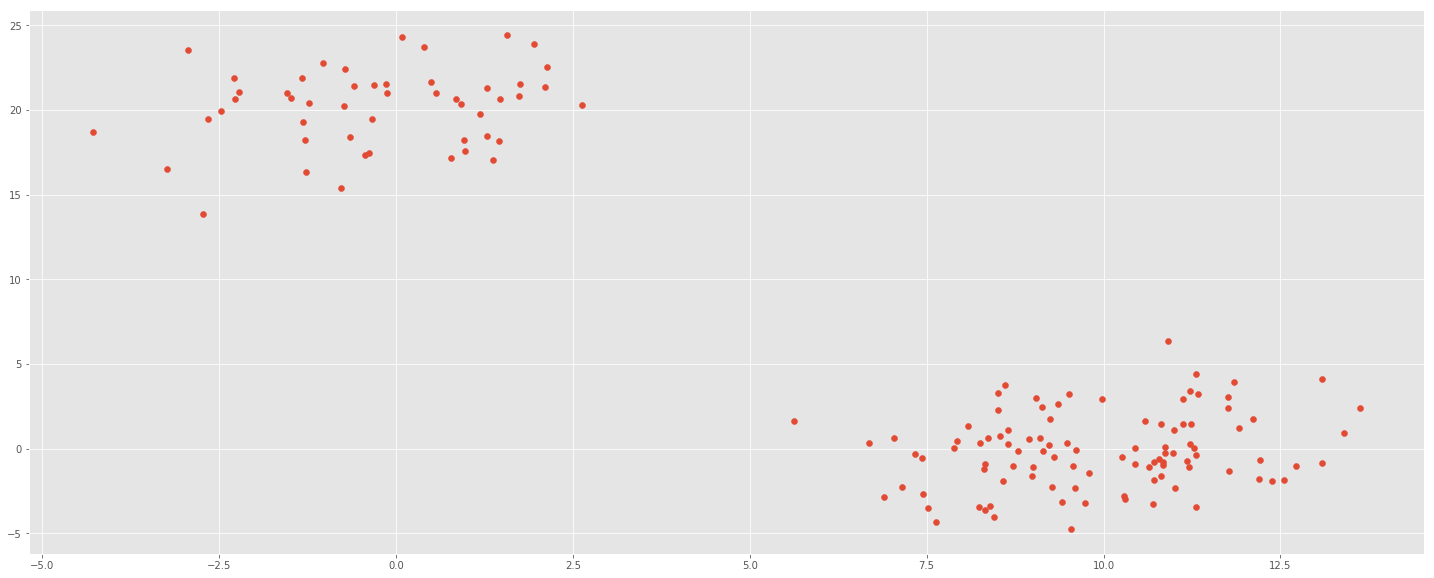

In [239]:
# 生成两个集群: 集群 a 有100个数据点, 集群 b 有50个数据点:
np.random.seed(1029)
a = np.random.multivariate_normal([10, 0], [[3, 1], [1, 4]], size=[100,])
b = np.random.multivariate_normal([0, 20], [[3, 1], [1, 4]], size=[50,])
X = np.concatenate((a, b),)
plt.figure(figsize=(25, 10))
plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [264]:
Z = linkage(reduced_data, "ward")

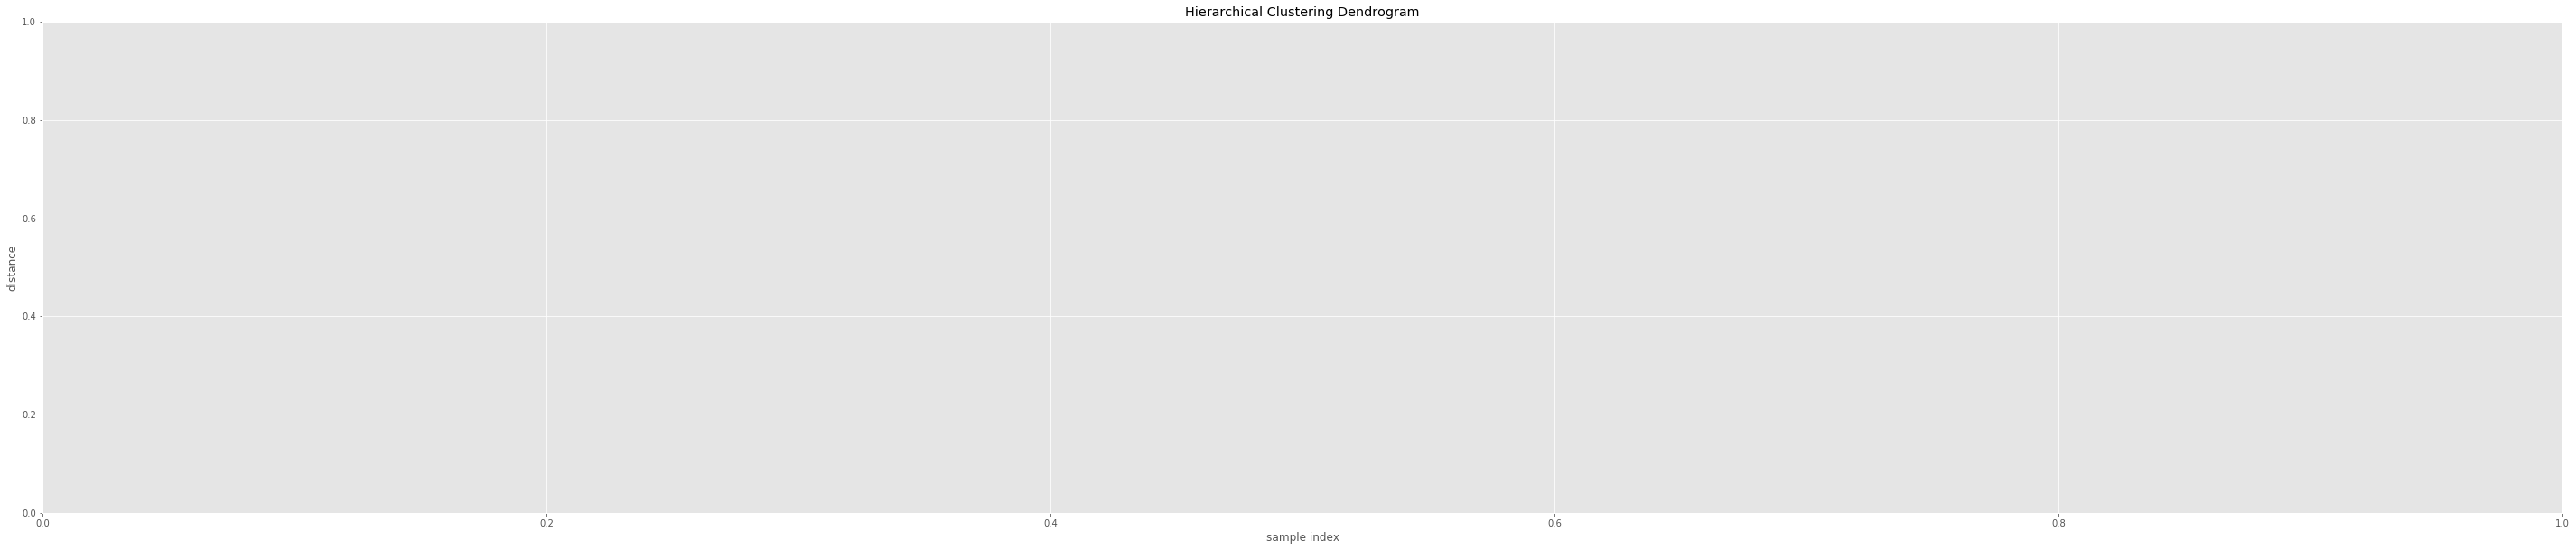

In [333]:
plt.figure(figsize=(50, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
?dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)
plt.show()

In [258]:
def fancy_dendrogram(*args, **kwargs):
	max_d = kwargs.pop('max_d', None)
	if max_d and 'color_threshold' not in kwargs:
		kwargs['color_threshold'] = max_d
	annotate_above = kwargs.pop('annotate_above', 0)

	ddata = dendrogram(*args, **kwargs)

	if not kwargs.get('no_plot', False):
		plt.title('Hierarchical Clustering Dendrogram (truncated)')
		plt.xlabel('sample index or (cluster size)')
		plt.ylabel('distance')
		for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
			x = 0.5 * sum(i[1:3])
			y = d[1]
			if y > annotate_above:
				plt.plot(x, y, 'o', c=c)
				plt.annotate("%.3g" % y, (x, y), xytext=(0, -5), textcoords='offset points', va='top', ha='center')
		if max_d:
			plt.axhline(y=max_d, c='k')
	return ddata

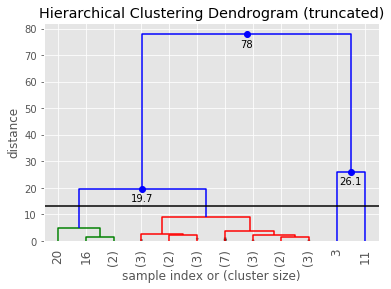

In [334]:
max_d = 13
fancy_dendrogram(Z, truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=12., show_contracted=True, annotate_above=10, max_d=max_d)
plt.show()

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print "Topic %d:" % (topic_idx)
        print " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])

In [343]:
feature = regression_ts.index.tolist()

In [ ]:
#Fit Topic Model
doctopic = clf.fit_transform(dtm)
topic_words = []
for topic in clf.components_:
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words.append([vocab[i] for i in word_idx])

In [59]:
from gensim import models
import seaborn as sns  #用于话热图的工具包
from scipy.cluster import hierarchy  #用于进行层次聚类，话层次聚类图的工具包
from scipy import cluster   
from sklearn import decomposition as skldec #用于主成分分析降维的包

In [89]:
from scipy.cluster.hierarchy import ward, dendrogram
linkage_matrix = ward(regression_ts) # 聚类算法处理之前计算得到的距离，用 linkage_matrix 表示

In [63]:
Z = hierarchy.linkage(regression_ts, method ='average',metric='euclidean')

{'color_list': ['g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'r',
  'b'],
 'dcoord': [[0.0, 3867.8531512972413, 3867.8531512972413, 0.0],
  [0.0, 6034.355958414262, 6034.355958414262, 3867.8531512972413],
  [0.0, 7429.433104031709, 7429.433104031709, 6034.355958414262],
  [0.0, 3761.626642823554, 3761.626642823554, 0.0],
  [0.0, 4975.411922470174, 4975.411922470174, 3761.626642823554],
  [0.0, 2719.3565415369862, 2719.3565415369862, 0.0],
  [0.0, 3603.255392758667, 3603.255392758667, 2719.3565415369862],
  [0.0, 3769.3432008780455, 3769.3432008780455, 3603.255392758667],
  [0.0, 2237.7075322749397, 2237.7075322749397, 0.0],
  [0.0, 2667.179415145876, 2667.179415145876, 2237.7075322749397],
  [0.0, 2978.811843671903, 2978.811843671903, 0.0],
  [0.0, 3384.4024033694977, 3384.4024033694977, 2978.811843671903],
  [2667.179415145876,
   3795.530558876982,


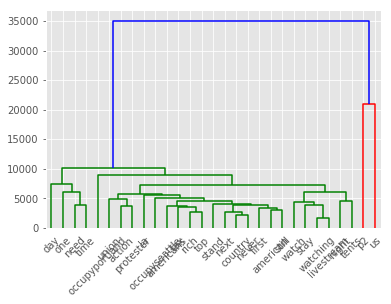

In [64]:
hierarchy.dendrogram(Z,labels = regression_ts.index)

In [ ]:
linkage_

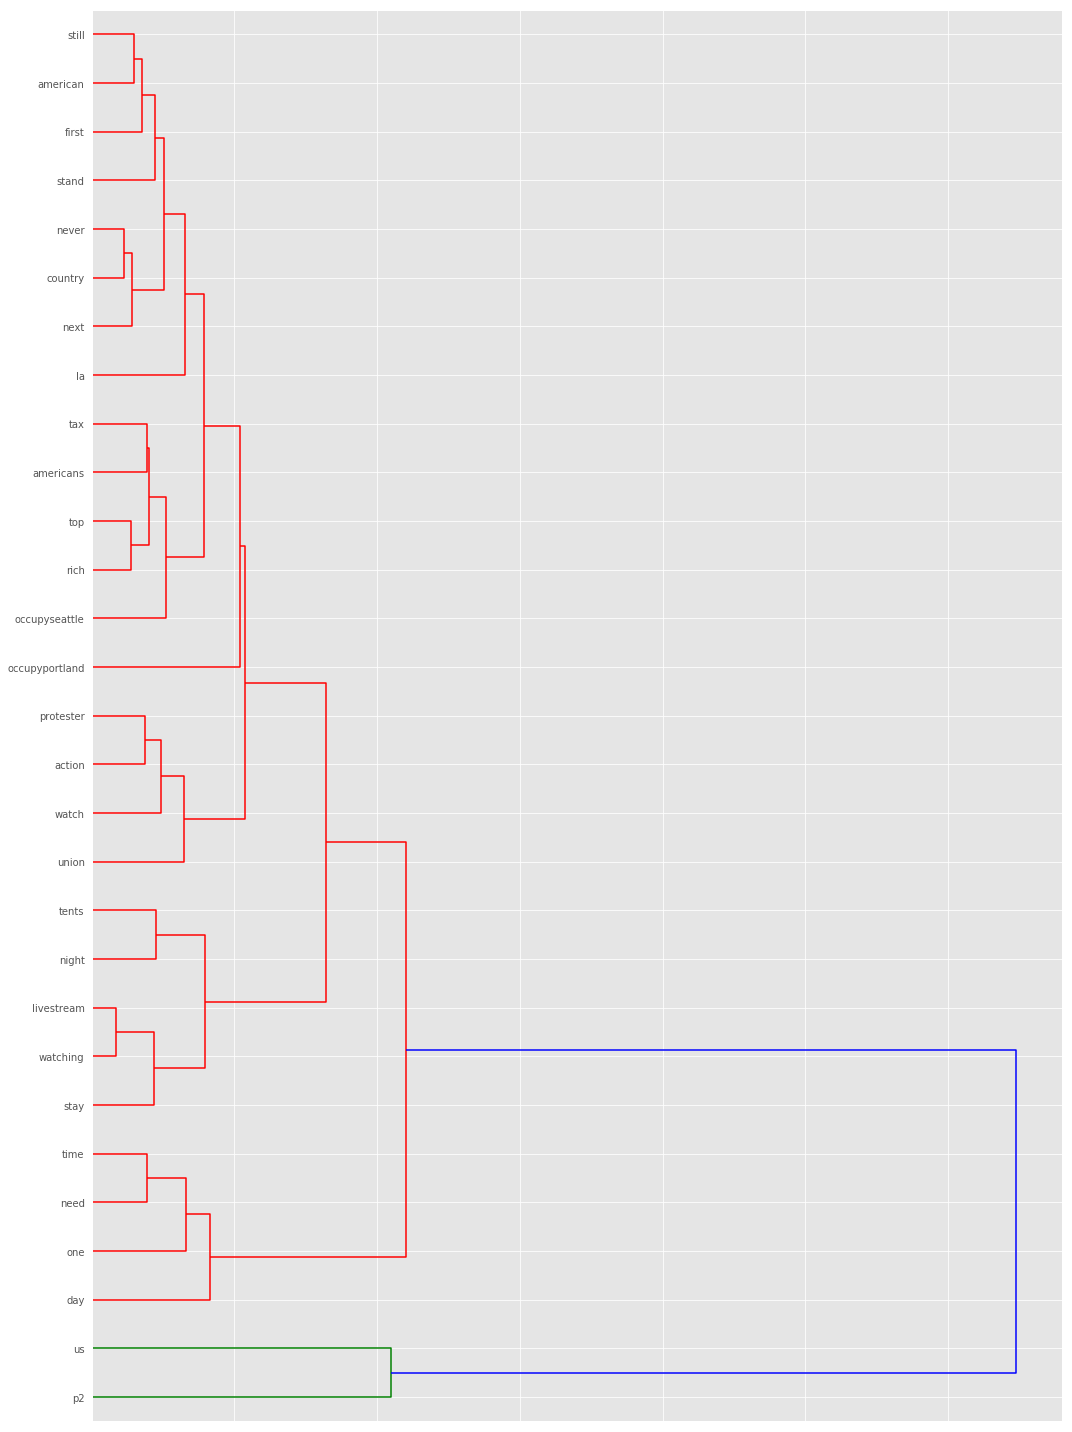

In [92]:
fig, ax = plt.subplots(figsize=(15, 20)) # 设置大小
ax = dendrogram(linkage_matrix, orientation="right", labels= regression_ts.index.tolist(), leaf_rotation = 0);
 
plt.tick_params(
        axis= 'x',          # 使用 x 坐标轴
        which='both',      # 同时使用主刻度标签（major ticks）和次刻度标签（minor ticks）
        bottom='off',      # 取消底部边缘（bottom edge）标签
        top='off',         # 取消顶部边缘（top edge）标签
    labelbottom='off')
 
plt.tight_layout() # 展示紧凑的绘图布局

In [74]:
from scipy.cluster.hierarchy import dendrogram, linkage

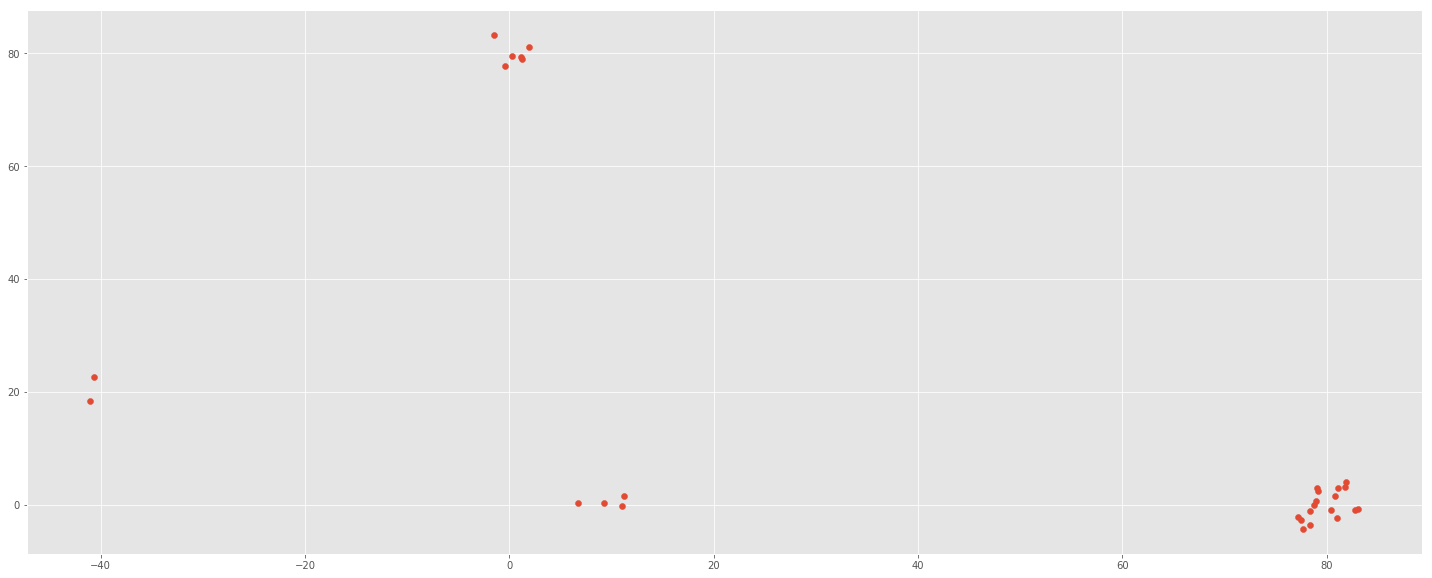

In [100]:
np.random.seed(1029)
a = np.random.multivariate_normal([10, 0], [[3, 1], [1, 4]], size=[4,])
b = np.random.multivariate_normal([-40, 20], [[3, 1], [1, 4]], size=[2,])
c = np.random.multivariate_normal([0, 80], [[3, 1], [1, 4]], size=[6,])
d = np.random.multivariate_normal([80, 0], [[3, 1], [1, 4]], size=[17,])
X = np.concatenate((a, b,c,d),)
plt.figure(figsize=(25, 10))
plt.scatter(X[:, 0], X[:, 1])
plt.show()

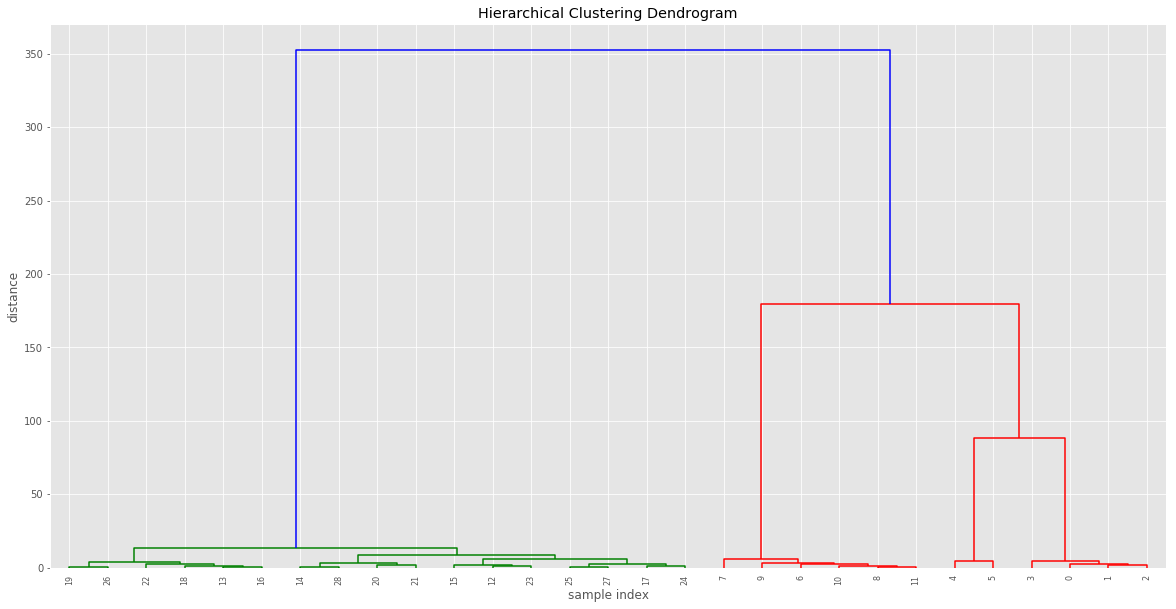

In [103]:
Z = linkage(X, 'ward')

plt.figure(figsize=(20, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(Z, leaf_rotation=90., leaf_font_size=8.
)
plt.show()

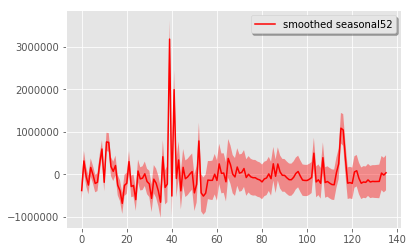

In [128]:
# Plot each component (attribute the time series to each component)
simple_dlm.turnOff('predict plot')
simple_dlm.turnOff('filtered plot')
# simple_dlm.plot('linear_trend')
simple_dlm.plot('seasonal52')

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


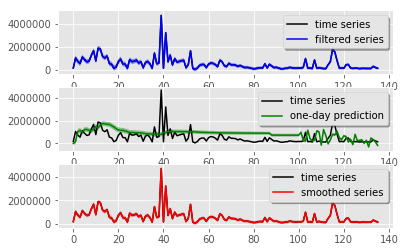

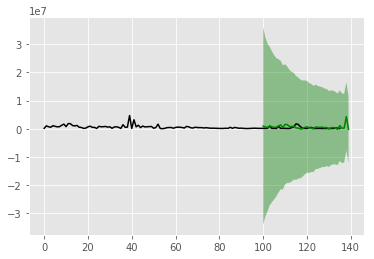

In [347]:
from pydlm import dlm, trend, seasonality
# A linear trend
linear_trend = trend(degree=1, discount=0.95, name='linear_trend', w=10)
# A seasonality
seasonal52 = seasonality(period=100, discount=0.9, name='seasonal52', w=10)
# Build a simple dlm
simple_dlm = dlm(top200_words_df['daliy_tweets']) + linear_trend + seasonal52


# Fit the model
simple_dlm.fit()
# Plot the fitted results
simple_dlm.turnOff('data points')
# fig = plt.figure(figsize=(20, 15),facecolor='white')
simple_dlm.plot()
# Plot the prediction give the first 351 weeks and forcast the next 200 weeks.
simple_dlm.plotPredictN(date=100, N=40)
# # Plot the prediction give the first 251 weeks and forcast the next 200 weeks.
#simple_dlm.plotPredictN(date=120, N=5)

In [423]:
hashframe = pd.read_pickle("./ows_data/hash_frame.pkl")

In [463]:
with open("./ows_data/hash_frame2.pkl", "wb") as f:
    pickle.dump(hashframe,f)

In [479]:
hashframes = hashframe.sort_index()

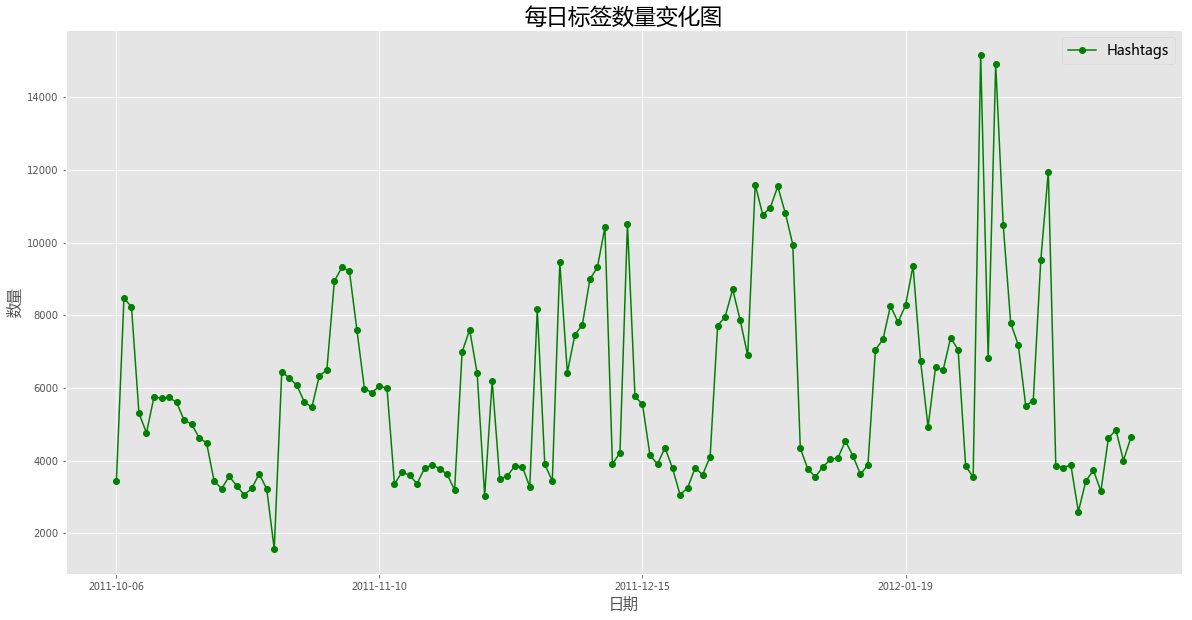

In [481]:
hashframe = pd.read_pickle(r"/Users/qinqiang/personal/tweets/ows_data/hash_frame2.pkl")

from matplotlib.font_manager import FontProperties
fig = plt.figure(figsize=(20, 10),facecolor='white')
font = FontProperties(fname=r"/Users/qinqiang/personal/tweets/msyh.ttf", size=14) 
# plt.subplot(1,2,1)
plt.plot(hashframes.date, hashframes.unique_hashtag, 'go-', label = u'Hashtags')
# plt.plot(daily_talk_df_raw.date, daily_talk_df_raw.total_tweets, 'b-', label = u'舆情走势')
# plt.plot(daily_talk_df_raw.date, daily_talk_df_raw.solo, 'y-o', label = u'自言自语行为')
# plt.plot(daily_talk_df.date, daily_talk_df.general_talk - daily_talk_df.interactive_talk, 'k-o', label = "other_tweets")

# plt.yscale('log') # plt.xscale('log')
x_xticks = np.arange(0, len(hashframes.date), 35)
plt.xticks(x_xticks, [hashframes.date[i] for i in x_xticks], rotation=0, fontproperties=font, fontsize = 10)
plt.axis('normal')
plt.ylabel(u'数量', fontproperties=font, fontsize=15)
plt.xlabel(u"日期", FontProperties = font, fontsize = 15)
plt.title(u'每日标签数量变化图',fontproperties=font,fontsize=22)
plt.legend(loc=1, fontsize = 8, prop = font)
plt.show()

In [486]:
hashframes.sort_values(by = "unique_hashtag", ascending = False)

,date,hashtag_number,unique_hashtag
115,2012-01-29,702247,15167
117,2012-01-31,615302,14918
124,2012-02-07,344717,11956
85,2011-12-30,343303,11599
88,2012-01-02,370081,11547
87,2012-01-01,303914,10960
89,2012-01-03,231185,10817
86,2011-12-31,250816,10764
68,2011-12-13,339991,10516
118,2012-02-01,268096,10481


### 方法二：经过词根化处理

In [157]:
# Part1：TOP200 TFIDF词
tfidf_objects_stemed = pd.read_pickle('./ows_data/clean_tweets_terms4_stemmed_removehashtags_tfidfmatrix.pkl')

In [ ]:
# Part2:之前计算的所有词根化的词时间序列
with open("./ows_data/word_date_freq_stemed.json", "r") as f:
    word_time_series = json.load(f)